<a href="https://colab.research.google.com/github/redhyppo/MAIMLF2020/blob/master/LC5_2020_NB_RNN_sequenzetemporali.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Sviluppo e training di RNN per analisi di sequenze temporali

### Informazioni ###

scopo: 
- apprendere uso e funzionalità delle RNN rispetto a una task tipica per queste architetture: predizioni di feature sulla base di esempi di serie temporali

**Dataset:**

dataset kaggle con andamento titolo di borsa Tata Global Beverages Ltd borsa Indiana

In [0]:
import tensorflow as tf 
print(tf.__version__)

from tensorflow import keras
from tensorflow.keras import layers

import numpy as np
import os
import time

import pandas as pd

from sklearn.preprocessing import MinMaxScaler

import matplotlib.pyplot as plt

if len(tf.config.list_physical_devices('GPU')) == 0:
    print('Per questa esercitazione è importante usare la GPU: cambia runtime: menu Runtime > Change Runtime Type > GPU)')

2.2.0


# Parte 1: predizione andamento titolo di borsa

In [0]:
# Dataset 
!rm -rf NSE-TATAGLOBAL.csv
!rm -rf NSE-TATAGLOBAL-test.csv
!wget http://giagu.web.cern.ch/giagu/CERN/NSE-TATAGLOBAL.csv
!wget http://giagu.web.cern.ch/giagu/CERN/NSE-TATAGLOBAL-test.csv
!ls 

--2020-06-15 22:45:09--  http://giagu.web.cern.ch/giagu/CERN/NSE-TATAGLOBAL.csv
Resolving giagu.web.cern.ch (giagu.web.cern.ch)... 188.184.101.49, 2001:1458:d00:35::100:35
Connecting to giagu.web.cern.ch (giagu.web.cern.ch)|188.184.101.49|:80... connected.
HTTP request sent, awaiting response... 200 OK
Length: 115525 (113K) [text/csv]
Saving to: ‘NSE-TATAGLOBAL.csv’

NSE-TATAGLOBAL.csv  100%[===================>] 112.82K   148KB/s    in 0.8s    

2020-06-15 22:45:11 (148 KB/s) - ‘NSE-TATAGLOBAL.csv’ saved [115525/115525]

--2020-06-15 22:45:13--  http://giagu.web.cern.ch/giagu/CERN/NSE-TATAGLOBAL-test.csv
Resolving giagu.web.cern.ch (giagu.web.cern.ch)... 188.184.101.49, 2001:1458:d00:35::100:35
Connecting to giagu.web.cern.ch (giagu.web.cern.ch)|188.184.101.49|:80... connected.
HTTP request sent, awaiting response... 200 OK
Length: 984 [text/csv]
Saving to: ‘NSE-TATAGLOBAL-test.csv’

NSE-TATAGLOBAL-test 100%[===================>]     984  --.-KB/s    in 0s      

2020-06-15 22:45:13 (

In [0]:
# Usiamo pandas per leggere il dataset in formato csv

# training data
df = pd.read_csv('NSE-TATAGLOBAL.csv')
# test data
df_test = pd.read_csv('NSE-TATAGLOBAL-test.csv')

In [0]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2035 entries, 0 to 2034
Data columns (total 8 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   Date                  2035 non-null   object 
 1   Open                  2035 non-null   float64
 2   High                  2035 non-null   float64
 3   Low                   2035 non-null   float64
 4   Last                  2035 non-null   float64
 5   Close                 2035 non-null   float64
 6   Total Trade Quantity  2035 non-null   int64  
 7   Turnover (Lacs)       2035 non-null   float64
dtypes: float64(6), int64(1), object(1)
memory usage: 127.3+ KB


In [0]:
df.head(5)

,Date,Open,High,Low,Last,Close,Total Trade Quantity,Turnover (Lacs)
0,2018-09-28,234.05,235.95,230.20,233.50,233.75,3069914,7162.35
1,2018-09-27,234.55,236.80,231.10,233.80,233.25,5082859,11859.95
2,2018-09-26,240.00,240.00,232.50,235.00,234.25,2240909,5248.60
3,2018-09-25,233.30,236.75,232.00,236.25,236.10,2349368,5503.90
4,2018-09-24,233.55,239.20,230.75,234.00,233.30,3423509,7999.55


In [0]:
df.columns

Index(['Date', 'Open', 'High', 'Low', 'Last', 'Close', 'Total Trade Quantity',
       'Turnover (Lacs)'],
      dtype='object')

In [0]:
# ordiniamo i valori in tempo crescente
df.sort_values('Date', inplace=True, ascending=True, ignore_index=True)
df_test.sort_values('Date', inplace=True, ascending=True, ignore_index=True)

In [0]:
print('Inizio della sequenza temporale: ', df.Date.min())
print('Fine della sequenza temporale: ', df.Date.max())

Inizio della sequenza temporale:  2010-07-21
Fine della sequenza temporale:  2018-09-28


In [0]:
print('Inizio della sequenza temporale (test set): ', df_test.Date.min())
print('Fine della sequenza temporale (test set): ', df_test.Date.max())

Inizio della sequenza temporale (test set):  2018-10-01
Fine della sequenza temporale (test set):  2018-10-24


In [0]:
df.head(5)

,Date,Open,High,Low,Last,Close,Total Trade Quantity,Turnover (Lacs)
0,2010-07-21,122.1,123.00,121.05,121.10,121.55,658666,803.56
1,2010-07-22,120.3,122.00,120.25,120.75,120.90,293312,355.17
2,2010-07-23,121.8,121.95,120.25,120.35,120.65,281312,340.31
3,2010-07-26,120.1,121.00,117.10,117.10,117.60,658440,780.01
4,2010-07-27,117.6,119.50,112.00,118.80,118.65,586100,694.98


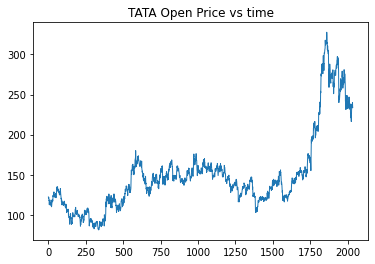

In [0]:
#Data Exploration

# grafichiamo la il prezzo di apertura in funzione della data

plt.plot(df['Open'],linewidth=1)
plt.title('TATA Open Price vs time')
plt.show()


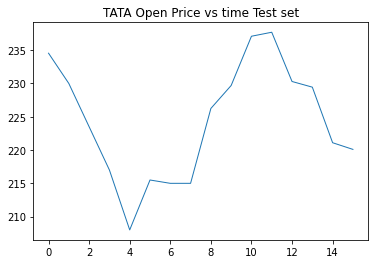

In [0]:
plt.plot(df_test['Open'],linewidth=1)
plt.title('TATA Open Price vs time Test set')
plt.show()


## Costruzione del modello RNN (una LSTM multilayer)

*   task: predire il vaore del titolo (feature *Open*) al tempo corrente a partire dalla storia del titolo a tempi precedenti 

Step necessari:

*   normalizzare le feature
*   split in training/validation
*   adeguare la shape dei dati per l'input atteso per una RNN in TF/keras: 3D array *(num_samples, num_timesteps, num_features)*
*   costruzione del modello in keras


In [0]:
# selezioniamo solo la feature interessante (Open price) e convertiamo i dati 
# in array numpy
training_set = df.iloc[:, 1:2].values

# normalizziamo le feature in [0,1], in questo caso solo per velocizzare il training
scaler = MinMaxScaler(feature_range = (0, 1))
training_set_scaled = scaler.fit_transform(training_set)

In [0]:
# Creiamo la strutura di dati adeguata per la RNN: 
# consideriamo timesteps campionamenti in cui osserviamo i valori del titolo a tempi
# precedenti, t-timetamp-delay ... t-delay
# e 1 output corrispondente al valore del titolo al tempo corrente  
# NOTA: nella RNN  input X timestamp valori a tempi precedenti e target X al tempo t
X_train = []
y_train = []

timesteps = 30 #numero di step temporali sequenziali usati per la predizione
delay = 0 #distanza in step temporali tra il target e l'elemento piu' vicino della sequenza temporale

for i in range(timesteps+delay, training_set.shape[0]):
    X_train.append(training_set_scaled[i-timesteps-delay:i-delay, 0])
    y_train.append(training_set_scaled[i, 0])

X_train, y_train = np.array(X_train), np.array(y_train)
print(X_train.shape)
print(y_train.shape)

(2005, 30)
(2005,)


In [0]:
# Reshaping nel formato atteso da una RNN in TF/keras: 3D array (num_samples, num_timesteps, num_features)
X_train = np.reshape(X_train, (X_train.shape[0], X_train.shape[1], 1))
print(X_train.shape)

(2005, 30, 1)


Architettura del modello di RNN:

1.   LSTM con 2 blocchi LSTM sequenziali (stacked LSTM) 
2.   spazio latente *ht* di dimensione 50
3.   dropout 20% per regolarizzare il modello
4.   un nuerone nell'output layer per predire la feature *Open*
5.   loss: MSE,  ottimizzatore: Adam
6.   100 epoche con EarlyStopping, con batch size 32


Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm (LSTM)                  (None, 30, 50)            10400     
_________________________________________________________________
dropout (Dropout)            (None, 30, 50)            0         
_________________________________________________________________
lstm_1 (LSTM)                (None, 50)                20200     
_________________________________________________________________
dropout_1 (Dropout)          (None, 50)                0         
_________________________________________________________________
dense (Dense)                (None, 1)                 51        
Total params: 30,651
Trainable params: 30,651
Non-trainable params: 0
_________________________________________________________________


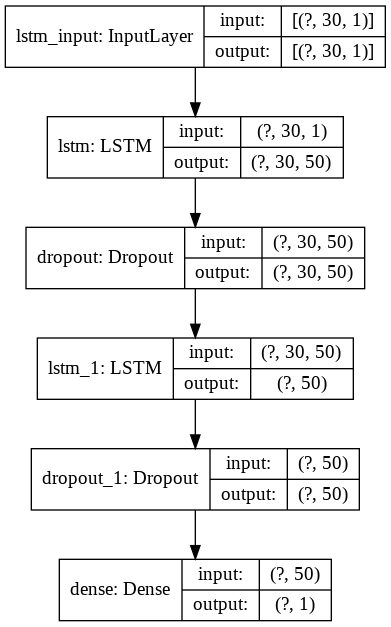

In [0]:
# Stacked LSTM layers con dropouts
model = keras.Sequential()

# return_sequences = True va usato quando l'output della LSTM serve come input 
# ad un'altra LSTM
model.add(layers.LSTM(50, return_sequences = True, input_shape=(X_train.shape[1], 1))) #50 imposta la dimensione dello spazio latente
model.add(layers.Dropout(0.2))

# nell'ultimo modulo LSTM non serve return_sequences = True
model.add(layers.LSTM(50))
model.add(layers.Dropout(0.2))

model.add(layers.Dense(1))

model.summary()
keras.utils.plot_model(model, show_shapes=True)

In [0]:
model.compile(optimizer='adam', loss='mean_squared_error')

history = model.fit(X_train, y_train,
                    epochs=100,
                    batch_size=32,
                    callbacks=[keras.callbacks.EarlyStopping(monitor='loss', patience=5)])

Epoch 1/100
63/63 [==============================] - 0s 6ms/step - loss: 0.0110
Epoch 2/100
63/63 [==============================] - 0s 6ms/step - loss: 0.0020
Epoch 3/100
63/63 [==============================] - 0s 6ms/step - loss: 0.0019
Epoch 4/100
63/63 [==============================] - 0s 6ms/step - loss: 0.0018
Epoch 5/100
63/63 [==============================] - 0s 6ms/step - loss: 0.0020
Epoch 6/100
63/63 [==============================] - 0s 6ms/step - loss: 0.0016
Epoch 7/100
63/63 [==============================] - 0s 6ms/step - loss: 0.0016
Epoch 8/100
63/63 [==============================] - 0s 6ms/step - loss: 0.0015
Epoch 9/100
63/63 [==============================] - 0s 6ms/step - loss: 0.0015
Epoch 10/100
63/63 [==============================] - 0s 6ms/step - loss: 0.0016
Epoch 11/100
63/63 [==============================] - 0s 6ms/step - loss: 0.0015
Epoch 12/100
63/63 [==============================] - 0s 6ms/step - loss: 0.0013
Epoch 13/100
63/63 [=================

In [0]:
# Calcoliamo la predizione del modello su i dati del test set (set degli stessi dati nel periodo subito 
# successivo)

test_set = df_test.iloc[:, 1:2].values

#concateniamo il dataset di training (che contiene le sequenze precedenti a quelle 
#del test set) con il test set
df_total = pd.concat((df['Open'], df_test['Open']), axis = 0)
inputs = df_total[(len(df_total) - len(df_test) - timesteps - delay):].values
inputs = inputs.reshape(-1,1) #nota -1 significa che numpy ricava la dimensione dalla lunghezza dell'array
inputs = scaler.transform(inputs) #normalizzazione

X_test = []
for i in range(timesteps+delay, timesteps+delay+test_set.shape[0]):
    start = i-(timesteps+delay)
    end = i-delay
    X_test.append(inputs[start:end, 0])

X_test = np.array(X_test)
X_test = np.reshape(X_test, (X_test.shape[0], X_test.shape[1], 1))

# predizione sul test set
predicted_values = model.predict(X_test)

# riconvertiamo indietro da [0,1] ai valori originali dell'prezzo di borsa
predicted_values = scaler.inverse_transform(predicted_values)

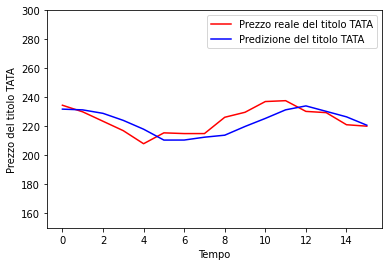

In [0]:
# Grafichiamo il risultato: predizione VS valore vero

plt.plot(test_set, color = 'red', label = 'Prezzo reale del titolo TATA')
plt.plot(predicted_values, color = 'blue', label = 'Predizione del titolo TATA')
plt.ylim(150, 300)
plt.xlabel('Tempo')
plt.ylabel('Prezzo del titolo TATA')
plt.legend()
plt.show()

# **Compiti:** 

1.   provare a vedere come cambiano le prestazioni riducendo la complessita della rete (dimensione spazio latente, numero di stack LSTM), e/o passando a RNN di tipo SimpleRNN e GRU
2.   pensare ad un modello naive basato sull'intuizione (vostra) del processo (esempio: la predizione a t potrebbe essere la media dei valori in n t precedenti tra i dati disponibili (dato il valore del delay), oppure il valore più vicino, ...) per stimare il valore del titolo al tempo corrente, misurarne le prestazioni sul test_set e confrontarlo con quanto ottenuto con la RNN ... commenti?
3.   provate a vedere come la qualità della predizione dipende dal numeo di eventi temporali (timestamps) utilizzati e sopratutto dalla distanza temporale (delay) tra l'ultima misura disponibile e il valore corrente. Come infuiscono sulle prestazioni?
4.   provate a costruire un campione di test ottenuto dalle predizioni sul campione di test stesso e iterare la procedura, cosa succede alla predizione?
5.   le prestazioni del modello migliorrebbero aggiungendo ulteriori feature nell'analisi temporale (per esempio: 'Total Trade Quantity' e 'Turnover (Lacs)')? Provare a capire come poter modificare il modello inserendo tali quantità e addestrando un nuovo modello ... (più complesso e opzionale)

#**Riduzione della complessità della rete**
Tentiamo diversi approcci per semplificare la rete implementata. Intendiamo quindi confrontare i risultati ottenuti con quelli relativi alla rete completa.

**Utilizzo di un solo layer LSTM** <br />
Eliminiamo uno dei layers LSTM e osserviamo il comportamento della rete.

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_2 (LSTM)                (None, 50)                10400     
_________________________________________________________________
dropout_2 (Dropout)          (None, 50)                0         
_________________________________________________________________
dense_1 (Dense)              (None, 1)                 51        
Total params: 10,451
Trainable params: 10,451
Non-trainable params: 0
_________________________________________________________________


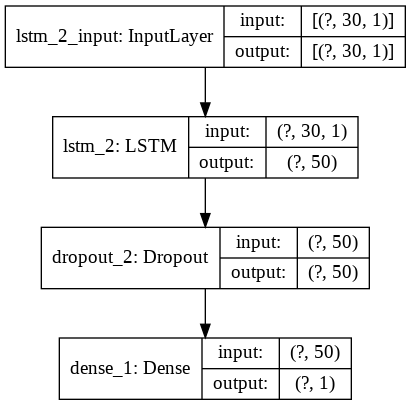

In [0]:
# Stacked LSTM layers con dropouts
model = keras.Sequential()

# return_sequences = True va usato quando l'output della LSTM serve come input 
# ad un'altra LSTM
model.add(layers.LSTM(50, return_sequences = False, input_shape=(X_train.shape[1], 1))) #25 imposta la dimensione dello spazio latente
model.add(layers.Dropout(0.2))

model.add(layers.Dense(1))

model.summary()
keras.utils.plot_model(model, show_shapes=True)

In [0]:
model.compile(optimizer='adam', loss='mean_squared_error')

history = model.fit(X_train, y_train,
                    epochs=100,
                    batch_size=32,
                    callbacks=[keras.callbacks.EarlyStopping(monitor='loss', patience=5)])

Epoch 1/100
63/63 [==============================] - 0s 4ms/step - loss: 0.0159
Epoch 2/100
63/63 [==============================] - 0s 4ms/step - loss: 0.0023
Epoch 3/100
63/63 [==============================] - 0s 4ms/step - loss: 0.0017
Epoch 4/100
63/63 [==============================] - 0s 4ms/step - loss: 0.0016
Epoch 5/100
63/63 [==============================] - 0s 4ms/step - loss: 0.0015
Epoch 6/100
63/63 [==============================] - 0s 4ms/step - loss: 0.0016
Epoch 7/100
63/63 [==============================] - 0s 4ms/step - loss: 0.0014
Epoch 8/100
63/63 [==============================] - 0s 4ms/step - loss: 0.0014
Epoch 9/100
63/63 [==============================] - 0s 4ms/step - loss: 0.0016
Epoch 10/100
63/63 [==============================] - 0s 4ms/step - loss: 0.0013
Epoch 11/100
63/63 [==============================] - 0s 4ms/step - loss: 0.0012
Epoch 12/100
63/63 [==============================] - 0s 4ms/step - loss: 0.0011
Epoch 13/100
63/63 [=================

In [0]:
# Calcoliamo la predizione del modello su i dati del test set (set degli stessi dati nel periodo subito 
# successivo)

test_set = df_test.iloc[:, 1:2].values

#concateniamo il dataset di training (che contiene le sequenze precedenti a quelle 
#del test set) con il test set
df_total = pd.concat((df['Open'], df_test['Open']), axis = 0)
inputs = df_total[(len(df_total) - len(df_test) - timesteps - delay):].values
inputs = inputs.reshape(-1,1) #nota -1 significa che numpy ricava la dimensione dalla lunghezza dell'array
inputs = scaler.transform(inputs) #normalizzazione

X_test = []
for i in range(timesteps+delay, timesteps+delay+test_set.shape[0]):
    start = i-(timesteps+delay)
    end = i-delay
    X_test.append(inputs[start:end, 0])

X_test = np.array(X_test)
X_test = np.reshape(X_test, (X_test.shape[0], X_test.shape[1], 1))

# predizione sul test set
predicted_values = model.predict(X_test)

# riconvertiamo indietro da [0,1] ai valori originali dell'prezzo di borsa
predicted_values = scaler.inverse_transform(predicted_values)

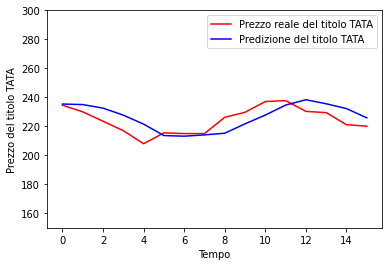

In [0]:
# Grafichiamo il risultato: predizione VS valore vero

plt.plot(test_set, color = 'red', label = 'Prezzo reale del titolo TATA')
plt.plot(predicted_values, color = 'blue', label = 'Predizione del titolo TATA')
plt.ylim(150, 300)
plt.xlabel('Tempo')
plt.ylabel('Prezzo del titolo TATA')
plt.legend()
plt.show()

Il grafico ottenuto differisce di poco da quello determinato dalla rete con due layers LSTM. Esso continua a non costituire un'approssimazione sufficientemente fedele dell'andamento reale. <br/>

**Riduzione della dimensione dello spazio latente** <br />
Proviamo a semplificare la rete utilizzata diminuendo la dimensionalità dello spazio latente. Passiamo da 50 a 10 dimensioni.

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_3 (LSTM)                (None, 30, 10)            480       
_________________________________________________________________
dropout_3 (Dropout)          (None, 30, 10)            0         
_________________________________________________________________
lstm_4 (LSTM)                (None, 10)                840       
_________________________________________________________________
dropout_4 (Dropout)          (None, 10)                0         
_________________________________________________________________
dense_2 (Dense)              (None, 1)                 11        
Total params: 1,331
Trainable params: 1,331
Non-trainable params: 0
_________________________________________________________________


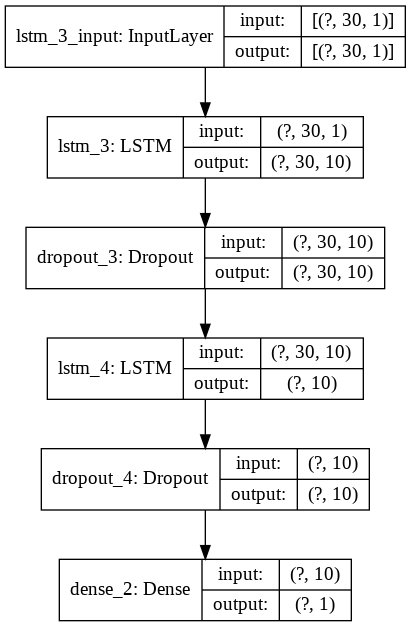

In [0]:
# Stacked LSTM layers con dropouts
model = keras.Sequential()

# return_sequences = True va usato quando l'output della LSTM serve come input 
# ad un'altra LSTM
model.add(layers.LSTM(10, return_sequences = True, input_shape=(X_train.shape[1], 1))) #25 imposta la dimensione dello spazio latente
model.add(layers.Dropout(0.2))

# nell'ultimo modulo LSTM non serve return_sequences = True
model.add(layers.LSTM(10))
model.add(layers.Dropout(0.2))

model.add(layers.Dense(1))

model.summary()
keras.utils.plot_model(model, show_shapes=True)

In [0]:
model.compile(optimizer='adam', loss='mean_squared_error')

history = model.fit(X_train, y_train,
                    epochs=100,
                    batch_size=32,
                    callbacks=[keras.callbacks.EarlyStopping(monitor='loss', patience=5)])

Epoch 1/100
63/63 [==============================] - 0s 6ms/step - loss: 0.0254
Epoch 2/100
63/63 [==============================] - 0s 6ms/step - loss: 0.0065
Epoch 3/100
63/63 [==============================] - 0s 6ms/step - loss: 0.0057
Epoch 4/100
63/63 [==============================] - 0s 6ms/step - loss: 0.0061
Epoch 5/100
63/63 [==============================] - 0s 6ms/step - loss: 0.0047
Epoch 6/100
63/63 [==============================] - 0s 6ms/step - loss: 0.0045
Epoch 7/100
63/63 [==============================] - 0s 6ms/step - loss: 0.0044
Epoch 8/100
63/63 [==============================] - 0s 6ms/step - loss: 0.0039
Epoch 9/100
63/63 [==============================] - 0s 6ms/step - loss: 0.0037
Epoch 10/100
63/63 [==============================] - 0s 6ms/step - loss: 0.0035
Epoch 11/100
63/63 [==============================] - 0s 6ms/step - loss: 0.0032
Epoch 12/100
63/63 [==============================] - 0s 6ms/step - loss: 0.0035
Epoch 13/100
63/63 [=================

In [0]:
# Calcoliamo la predizione del modello su i dati del test set (set degli stessi dati nel periodo subito 
# successivo)

test_set = df_test.iloc[:, 1:2].values

#concateniamo il dataset di training (che contiene le sequenze precedenti a quelle 
#del test set) con il test set
df_total = pd.concat((df['Open'], df_test['Open']), axis = 0)
inputs = df_total[(len(df_total) - len(df_test) - timesteps - delay):].values
inputs = inputs.reshape(-1,1) #nota -1 significa che numpy ricava la dimensione dalla lunghezza dell'array
inputs = scaler.transform(inputs) #normalizzazione

X_test = []
for i in range(timesteps+delay, timesteps+delay+test_set.shape[0]):
    start = i-(timesteps+delay)
    end = i-delay
    X_test.append(inputs[start:end, 0])

X_test = np.array(X_test)
X_test = np.reshape(X_test, (X_test.shape[0], X_test.shape[1], 1))

# predizione sul test set
predicted_values = model.predict(X_test)

# riconvertiamo indietro da [0,1] ai valori originali dell'prezzo di borsa
predicted_values = scaler.inverse_transform(predicted_values)

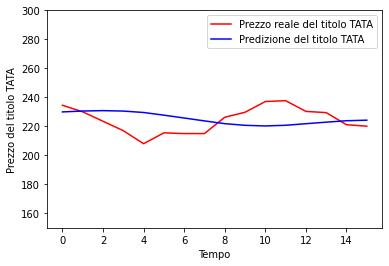

In [0]:
# Grafichiamo il risultato: predizione VS valore vero

plt.plot(test_set, color = 'red', label = 'Prezzo reale del titolo TATA')
plt.plot(predicted_values, color = 'blue', label = 'Predizione del titolo TATA')
plt.ylim(150, 300)
plt.xlabel('Tempo')
plt.ylabel('Prezzo del titolo TATA')
plt.legend()
plt.show()

L'operazione non ha portato a risultati accettabili: l'andamento prodotto non rispecchia minimamente quello reale. <br />
<br />
**Utilizzo di layer di tipo RNN** <br />
Modifichiamo ora la rete sostituendo i layers LSTM con dei SimpleRNN.

Model: "sequential_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
simple_rnn (SimpleRNN)       (None, 30, 50)            2600      
_________________________________________________________________
dropout_5 (Dropout)          (None, 30, 50)            0         
_________________________________________________________________
simple_rnn_1 (SimpleRNN)     (None, 50)                5050      
_________________________________________________________________
dropout_6 (Dropout)          (None, 50)                0         
_________________________________________________________________
dense_3 (Dense)              (None, 1)                 51        
Total params: 7,701
Trainable params: 7,701
Non-trainable params: 0
_________________________________________________________________


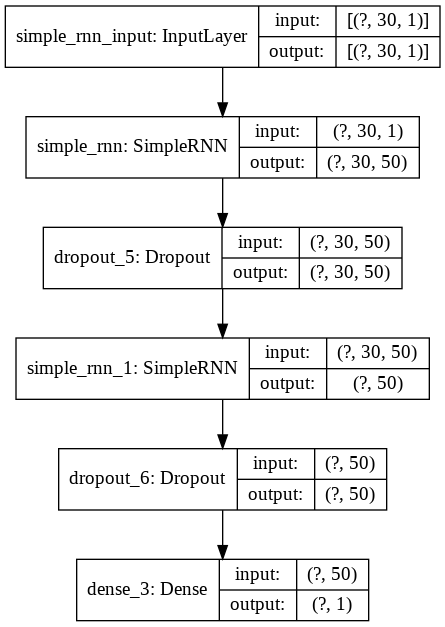

In [0]:
# Stacked LSTM layers con dropouts
model = keras.Sequential()

# return_sequences = True va usato quando l'output della LSTM serve come input 
# ad un'altra LSTM
model.add(layers.SimpleRNN(50, return_sequences = True, input_shape=(X_train.shape[1], 1))) #25 imposta la dimensione dello spazio latente
model.add(layers.Dropout(0.2))

# nell'ultimo modulo LSTM non serve return_sequences = True
model.add(layers.SimpleRNN(50))
model.add(layers.Dropout(0.2))

model.add(layers.Dense(1))

model.summary()
keras.utils.plot_model(model, show_shapes=True)

In [0]:
model.compile(optimizer='adam', loss='mean_squared_error')

history = model.fit(X_train, y_train,
                    epochs=100,
                    batch_size=32,
                    callbacks=[keras.callbacks.EarlyStopping(monitor='loss', patience=5)])

Epoch 1/100
63/63 [==============================] - 2s 39ms/step - loss: 0.0440
Epoch 2/100
63/63 [==============================] - 2s 38ms/step - loss: 0.0102
Epoch 3/100
63/63 [==============================] - 2s 38ms/step - loss: 0.0074
Epoch 4/100
63/63 [==============================] - 2s 38ms/step - loss: 0.0061
Epoch 5/100
63/63 [==============================] - 2s 39ms/step - loss: 0.0045
Epoch 6/100
63/63 [==============================] - 2s 39ms/step - loss: 0.0038
Epoch 7/100
63/63 [==============================] - 2s 39ms/step - loss: 0.0027
Epoch 8/100
63/63 [==============================] - 2s 38ms/step - loss: 0.0024
Epoch 9/100
63/63 [==============================] - 2s 37ms/step - loss: 0.0024
Epoch 10/100
63/63 [==============================] - 2s 38ms/step - loss: 0.0025
Epoch 11/100
63/63 [==============================] - 2s 38ms/step - loss: 0.0020
Epoch 12/100
63/63 [==============================] - 2s 39ms/step - loss: 0.0021
Epoch 13/100
63/63 [=====

In [0]:
# Calcoliamo la predizione del modello su i dati del test set (set degli stessi dati nel periodo subito 
# successivo)

test_set = df_test.iloc[:, 1:2].values

#concateniamo il dataset di training (che contiene le sequenze precedenti a quelle 
#del test set) con il test set
df_total = pd.concat((df['Open'], df_test['Open']), axis = 0)
inputs = df_total[(len(df_total) - len(df_test) - timesteps - delay):].values
inputs = inputs.reshape(-1,1) #nota -1 significa che numpy ricava la dimensione dalla lunghezza dell'array
inputs = scaler.transform(inputs) #normalizzazione

X_test = []
for i in range(timesteps+delay, timesteps+delay+test_set.shape[0]):
    start = i-(timesteps+delay)
    end = i-delay
    X_test.append(inputs[start:end, 0])

X_test = np.array(X_test)
X_test = np.reshape(X_test, (X_test.shape[0], X_test.shape[1], 1))

# predizione sul test set
predicted_values = model.predict(X_test)

# riconvertiamo indietro da [0,1] ai valori originali dell'prezzo di borsa
predicted_values = scaler.inverse_transform(predicted_values)

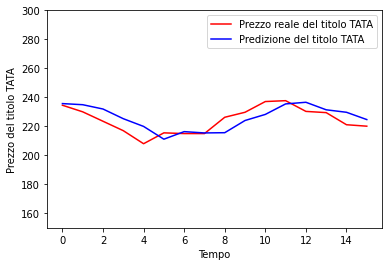

In [0]:
# Grafichiamo il risultato: predizione VS valore vero

plt.plot(test_set, color = 'red', label = 'Prezzo reale del titolo TATA')
plt.plot(predicted_values, color = 'blue', label = 'Predizione del titolo TATA')
plt.ylim(150, 300)
plt.xlabel('Tempo')
plt.ylabel('Prezzo del titolo TATA')
plt.legend()
plt.show()

L'introduzione dei layers SimpleRNN ha favorito il corretto funzionamento dell'algoritmo, che è ora in grado di produrre una curva piuttosto simile a quella dell'andamento reale. <br />
<br />
**Uso della GRU** <br />
In ultimo, testiamo un layer di tipo GRU al posto di LSTM.

Model: "sequential_4"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
gru (GRU)                    (None, 30, 50)            7950      
_________________________________________________________________
dropout_7 (Dropout)          (None, 30, 50)            0         
_________________________________________________________________
gru_1 (GRU)                  (None, 50)                15300     
_________________________________________________________________
dropout_8 (Dropout)          (None, 50)                0         
_________________________________________________________________
dense_4 (Dense)              (None, 1)                 51        
Total params: 23,301
Trainable params: 23,301
Non-trainable params: 0
_________________________________________________________________


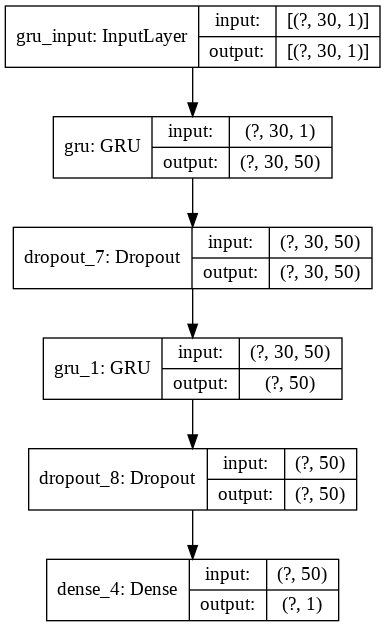

In [0]:
# Stacked LSTM layers con dropouts
model = keras.Sequential()

# return_sequences = True va usato quando l'output della LSTM serve come input 
# ad un'altra LSTM
model.add(layers.GRU(50, return_sequences = True, input_shape=(X_train.shape[1], 1))) #25 imposta la dimensione dello spazio latente
model.add(layers.Dropout(0.2))

# nell'ultimo modulo LSTM non serve return_sequences = True
model.add(layers.GRU(50))
model.add(layers.Dropout(0.2))

model.add(layers.Dense(1))

model.summary()
keras.utils.plot_model(model, show_shapes=True)

In [0]:
model.compile(optimizer='adam', loss='mean_squared_error')

history = model.fit(X_train, y_train,
                    epochs=100,
                    batch_size=32,
                    callbacks=[keras.callbacks.EarlyStopping(monitor='loss', patience=5)])

Epoch 1/100
63/63 [==============================] - 0s 6ms/step - loss: 0.0097
Epoch 2/100
63/63 [==============================] - 0s 6ms/step - loss: 0.0017
Epoch 3/100
63/63 [==============================] - 0s 6ms/step - loss: 0.0016
Epoch 4/100
63/63 [==============================] - 0s 6ms/step - loss: 0.0016
Epoch 5/100
63/63 [==============================] - 0s 6ms/step - loss: 0.0014
Epoch 6/100
63/63 [==============================] - 0s 6ms/step - loss: 0.0014
Epoch 7/100
63/63 [==============================] - 0s 6ms/step - loss: 0.0012
Epoch 8/100
63/63 [==============================] - 0s 6ms/step - loss: 0.0013
Epoch 9/100
63/63 [==============================] - 0s 6ms/step - loss: 0.0011
Epoch 10/100
63/63 [==============================] - 0s 6ms/step - loss: 0.0012
Epoch 11/100
63/63 [==============================] - 0s 6ms/step - loss: 0.0011
Epoch 12/100
63/63 [==============================] - 0s 6ms/step - loss: 0.0011
Epoch 13/100
63/63 [=================

In [0]:
# Calcoliamo la predizione del modello su i dati del test set (set degli stessi dati nel periodo subito 
# successivo)

test_set = df_test.iloc[:, 1:2].values

#concateniamo il dataset di training (che contiene le sequenze precedenti a quelle 
#del test set) con il test set
df_total = pd.concat((df['Open'], df_test['Open']), axis = 0)
inputs = df_total[(len(df_total) - len(df_test) - timesteps - delay):].values
inputs = inputs.reshape(-1,1) #nota -1 significa che numpy ricava la dimensione dalla lunghezza dell'array
inputs = scaler.transform(inputs) #normalizzazione

X_test = []
for i in range(timesteps+delay, timesteps+delay+test_set.shape[0]):
    start = i-(timesteps+delay)
    end = i-delay
    X_test.append(inputs[start:end, 0])

X_test = np.array(X_test)
X_test = np.reshape(X_test, (X_test.shape[0], X_test.shape[1], 1))

# predizione sul test set
predicted_values = model.predict(X_test)

# riconvertiamo indietro da [0,1] ai valori originali dell'prezzo di borsa
predicted_values = scaler.inverse_transform(predicted_values)

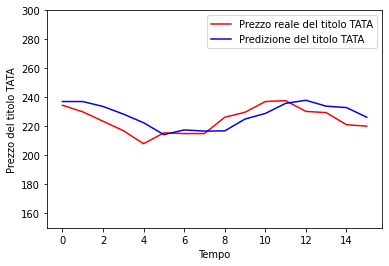

In [0]:
# Grafichiamo il risultato: predizione VS valore vero

plt.plot(test_set, color = 'red', label = 'Prezzo reale del titolo TATA')
plt.plot(predicted_values, color = 'blue', label = 'Predizione del titolo TATA')
plt.ylim(150, 300)
plt.xlabel('Tempo')
plt.ylabel('Prezzo del titolo TATA')
plt.legend()
plt.show()

Anche l'implementazione dei layers GRU consente all'algoritmo di produrre risultati migliori: l'approssimazione risultante, sebbene appaia meno accurata di quella ottenuta con SimpleRNN, fornisce comunque un'accuratezza migliore di quella derivata dai layers LSTM.

#**Dipendenza dai parametri della simulazione**
Ci proponiamo ora di valutare l'incidenza sulla predizione del numero di eventi temporali considerati (quantificato dalla variabile *timesteps*), nonché della distanza temporale tra l'ultimo evento considerato ed il tempo corrente (espressa tramite la variabile *delay*). <br />
<br />
***Timesteps***<br />
Cominciamo diminuendo il numero di eventi utilizzati a *timesteps*=15.

In [0]:
# selezioniamo solo la feature interessante (Open price) e convertiamo i dati 
# in array numpy
training_set = df.iloc[:, 1:2].values

# normalizziamo le feature in [0,1], in questo caso solo per velocizzare il training
scaler = MinMaxScaler(feature_range = (0, 1))
training_set_scaled = scaler.fit_transform(training_set)

In [0]:
# Creiamo la strutura di dati adeguata per la RNN: 
# consideriamo timesteps campionamenti in cui osserviamo i valori del titolo a tempi
# precedenti, t-timetamp-delay ... t-delay
# e 1 output corrispondente al valore del titolo al tempo corrente  
# NOTA: nella RNN  input X timestamp valori a tempi precedenti e target X al tempo t
X_train = []
y_train = []

timesteps = 15 #numero di step temporali sequenziali usati per la predizione
delay = 0 #distanza in step temporali tra il target e l'elemento piu' vicino della sequenza temporale

for i in range(timesteps+delay, training_set.shape[0]):
    X_train.append(training_set_scaled[i-timesteps-delay:i-delay, 0])
    y_train.append(training_set_scaled[i, 0])

X_train, y_train = np.array(X_train), np.array(y_train)
print(X_train.shape)
print(y_train.shape)

(2020, 15)
(2020,)


In [0]:
# Reshaping nel formato atteso da una RNN in TF/keras: 3D array (num_samples, num_timesteps, num_features)
X_train = np.reshape(X_train, (X_train.shape[0], X_train.shape[1], 1))
print(X_train.shape)

(2020, 15, 1)


Model: "sequential_5"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_5 (LSTM)                (None, 15, 50)            10400     
_________________________________________________________________
dropout_9 (Dropout)          (None, 15, 50)            0         
_________________________________________________________________
lstm_6 (LSTM)                (None, 50)                20200     
_________________________________________________________________
dropout_10 (Dropout)         (None, 50)                0         
_________________________________________________________________
dense_5 (Dense)              (None, 1)                 51        
Total params: 30,651
Trainable params: 30,651
Non-trainable params: 0
_________________________________________________________________


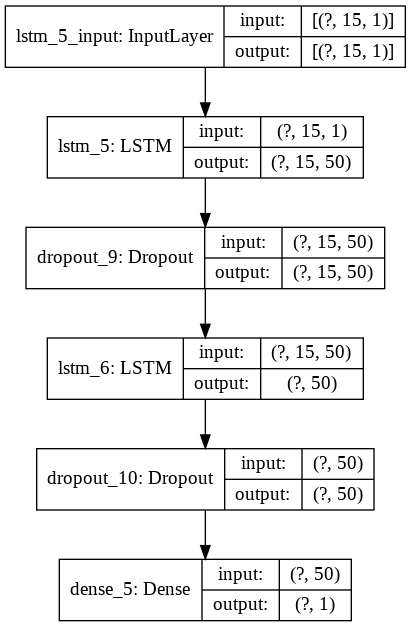

In [0]:
# Stacked LSTM layers con dropouts
model = keras.Sequential()

# return_sequences = True va usato quando l'output della LSTM serve come input 
# ad un'altra LSTM
model.add(layers.LSTM(50, return_sequences = True, input_shape=(X_train.shape[1], 1))) #50 imposta la dimensione dello spazio latente
model.add(layers.Dropout(0.2))

# nell'ultimo modulo LSTM non serve return_sequences = True
model.add(layers.LSTM(50))
model.add(layers.Dropout(0.2))

model.add(layers.Dense(1))

model.summary()
keras.utils.plot_model(model, show_shapes=True)

In [0]:
model.compile(optimizer='adam', loss='mean_squared_error')

history = model.fit(X_train, y_train,
                    epochs=100,
                    batch_size=32,
                    callbacks=[keras.callbacks.EarlyStopping(monitor='loss', patience=5)])

Epoch 1/100
64/64 [==============================] - 0s 5ms/step - loss: 0.0121
Epoch 2/100
64/64 [==============================] - 0s 5ms/step - loss: 0.0022
Epoch 3/100
64/64 [==============================] - 0s 5ms/step - loss: 0.0022
Epoch 4/100
64/64 [==============================] - 0s 5ms/step - loss: 0.0017
Epoch 5/100
64/64 [==============================] - 0s 5ms/step - loss: 0.0018
Epoch 6/100
64/64 [==============================] - 0s 5ms/step - loss: 0.0017
Epoch 7/100
64/64 [==============================] - 0s 5ms/step - loss: 0.0016
Epoch 8/100
64/64 [==============================] - 0s 5ms/step - loss: 0.0016
Epoch 9/100
64/64 [==============================] - 0s 5ms/step - loss: 0.0016
Epoch 10/100
64/64 [==============================] - 0s 5ms/step - loss: 0.0015
Epoch 11/100
64/64 [==============================] - 0s 5ms/step - loss: 0.0014
Epoch 12/100
64/64 [==============================] - 0s 5ms/step - loss: 0.0013
Epoch 13/100
64/64 [=================

In [0]:
# Calcoliamo la predizione del modello su i dati del test set (set degli stessi dati nel periodo subito 
# successivo)

test_set = df_test.iloc[:, 1:2].values

#concateniamo il dataset di training (che contiene le sequenze precedenti a quelle 
#del test set) con il test set
df_total = pd.concat((df['Open'], df_test['Open']), axis = 0)
inputs = df_total[(len(df_total) - len(df_test) - timesteps - delay):].values
inputs = inputs.reshape(-1,1) #nota -1 significa che numpy ricava la dimensione dalla lunghezza dell'array
inputs = scaler.transform(inputs) #normalizzazione

X_test = []
for i in range(timesteps+delay, timesteps+delay+test_set.shape[0]):
    start = i-(timesteps+delay)
    end = i-delay
    X_test.append(inputs[start:end, 0])

X_test = np.array(X_test)
X_test = np.reshape(X_test, (X_test.shape[0], X_test.shape[1], 1))

# predizione sul test set
predicted_values = model.predict(X_test)

# riconvertiamo indietro da [0,1] ai valori originali dell'prezzo di borsa
predicted_values = scaler.inverse_transform(predicted_values)

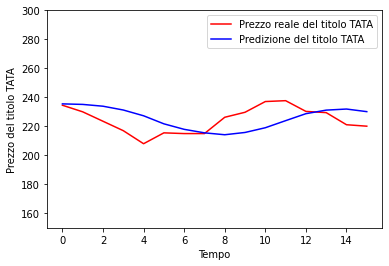

In [0]:
# Grafichiamo il risultato: predizione VS valore vero

plt.plot(test_set, color = 'red', label = 'Prezzo reale del titolo TATA')
plt.plot(predicted_values, color = 'blue', label = 'Predizione del titolo TATA')
plt.ylim(150, 300)
plt.xlabel('Tempo')
plt.ylabel('Prezzo del titolo TATA')
plt.legend()
plt.show()

Come ci aspettavamo, la qualità della previsione peggiora se questa viene effettuata sulla base di un numero minore di eventi. <br/>
Proviamo allora ad aumentare il numero di eventi a *timesteps*=60.

In [0]:
# selezioniamo solo la feature interessante (Open price) e convertiamo i dati 
# in array numpy
training_set = df.iloc[:, 1:2].values

# normalizziamo le feature in [0,1], in questo caso solo per velocizzare il training
scaler = MinMaxScaler(feature_range = (0, 1))
training_set_scaled = scaler.fit_transform(training_set)

In [0]:
# Creiamo la strutura di dati adeguata per la RNN: 
# consideriamo timesteps campionamenti in cui osserviamo i valori del titolo a tempi
# precedenti, t-timetamp-delay ... t-delay
# e 1 output corrispondente al valore del titolo al tempo corrente  
# NOTA: nella RNN  input X timestamp valori a tempi precedenti e target X al tempo t
X_train = []
y_train = []

timesteps = 60 #numero di step temporali sequenziali usati per la predizione
delay = 0 #distanza in step temporali tra il target e l'elemento piu' vicino della sequenza temporale

for i in range(timesteps+delay, training_set.shape[0]):
    X_train.append(training_set_scaled[i-timesteps-delay:i-delay, 0])
    y_train.append(training_set_scaled[i, 0])

X_train, y_train = np.array(X_train), np.array(y_train)
print(X_train.shape)
print(y_train.shape)

(1975, 60)
(1975,)


In [0]:
# Reshaping nel formato atteso da una RNN in TF/keras: 3D array (num_samples, num_timesteps, num_features)
X_train = np.reshape(X_train, (X_train.shape[0], X_train.shape[1], 1))
print(X_train.shape)

(1975, 60, 1)


Model: "sequential_6"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_7 (LSTM)                (None, 60, 50)            10400     
_________________________________________________________________
dropout_11 (Dropout)         (None, 60, 50)            0         
_________________________________________________________________
lstm_8 (LSTM)                (None, 50)                20200     
_________________________________________________________________
dropout_12 (Dropout)         (None, 50)                0         
_________________________________________________________________
dense_6 (Dense)              (None, 1)                 51        
Total params: 30,651
Trainable params: 30,651
Non-trainable params: 0
_________________________________________________________________


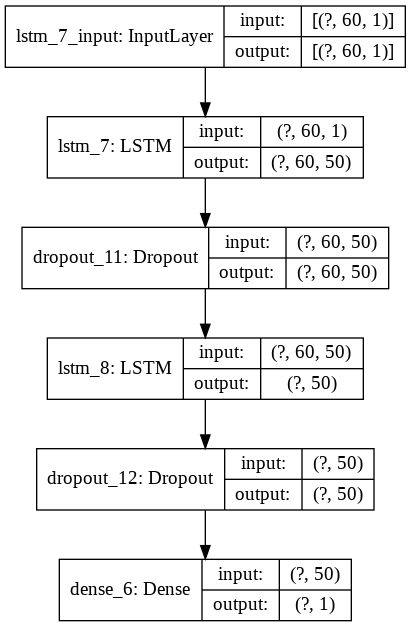

In [0]:
# Stacked LSTM layers con dropouts
model = keras.Sequential()

# return_sequences = True va usato quando l'output della LSTM serve come input 
# ad un'altra LSTM
model.add(layers.LSTM(50, return_sequences = True, input_shape=(X_train.shape[1], 1))) #50 imposta la dimensione dello spazio latente
model.add(layers.Dropout(0.2))

# nell'ultimo modulo LSTM non serve return_sequences = True
model.add(layers.LSTM(50))
model.add(layers.Dropout(0.2))

model.add(layers.Dense(1))

model.summary()
keras.utils.plot_model(model, show_shapes=True)

In [0]:
model.compile(optimizer='adam', loss='mean_squared_error')

history = model.fit(X_train, y_train,
                    epochs=100,
                    batch_size=32,
                    callbacks=[keras.callbacks.EarlyStopping(monitor='loss', patience=5)])

Epoch 1/100
62/62 [==============================] - 0s 8ms/step - loss: 0.0072
Epoch 2/100
62/62 [==============================] - 0s 8ms/step - loss: 0.0025
Epoch 3/100
62/62 [==============================] - 0s 8ms/step - loss: 0.0020
Epoch 4/100
62/62 [==============================] - 0s 7ms/step - loss: 0.0020
Epoch 5/100
62/62 [==============================] - 0s 8ms/step - loss: 0.0020
Epoch 6/100
62/62 [==============================] - 0s 7ms/step - loss: 0.0017
Epoch 7/100
62/62 [==============================] - 0s 7ms/step - loss: 0.0018
Epoch 8/100
62/62 [==============================] - 0s 7ms/step - loss: 0.0015
Epoch 9/100
62/62 [==============================] - 0s 7ms/step - loss: 0.0015
Epoch 10/100
62/62 [==============================] - 0s 8ms/step - loss: 0.0015
Epoch 11/100
62/62 [==============================] - 0s 7ms/step - loss: 0.0013
Epoch 12/100
62/62 [==============================] - 0s 8ms/step - loss: 0.0014
Epoch 13/100
62/62 [=================

In [0]:
# Calcoliamo la predizione del modello su i dati del test set (set degli stessi dati nel periodo subito 
# successivo)

test_set = df_test.iloc[:, 1:2].values

#concateniamo il dataset di training (che contiene le sequenze precedenti a quelle 
#del test set) con il test set
df_total = pd.concat((df['Open'], df_test['Open']), axis = 0)
inputs = df_total[(len(df_total) - len(df_test) - timesteps - delay):].values
inputs = inputs.reshape(-1,1) #nota -1 significa che numpy ricava la dimensione dalla lunghezza dell'array
inputs = scaler.transform(inputs) #normalizzazione

X_test = []
for i in range(timesteps+delay, timesteps+delay+test_set.shape[0]):
    start = i-(timesteps+delay)
    end = i-delay
    X_test.append(inputs[start:end, 0])

X_test = np.array(X_test)
X_test = np.reshape(X_test, (X_test.shape[0], X_test.shape[1], 1))

# predizione sul test set
predicted_values = model.predict(X_test)

# riconvertiamo indietro da [0,1] ai valori originali dell'prezzo di borsa
predicted_values = scaler.inverse_transform(predicted_values)

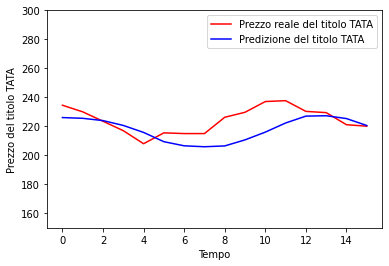

In [0]:
# Grafichiamo il risultato: predizione VS valore vero

plt.plot(test_set, color = 'red', label = 'Prezzo reale del titolo TATA')
plt.plot(predicted_values, color = 'blue', label = 'Predizione del titolo TATA')
plt.ylim(150, 300)
plt.xlabel('Tempo')
plt.ylabel('Prezzo del titolo TATA')
plt.legend()
plt.show()

L'aumento del numero di eventi sembra sortire come effetto una "regolarizzazione" della curva, la quale tuttavia non approssima in modo più accurato l'andamento reale del titolo. Al contrario, la qualità della previsione sembra peggiorare anche in questo caso. <br />
<br />
***Delay*** <br />
Osserviamo ora la reazione della previsione della rete se si incrementa di un'unità il *delay*.

In [0]:
# selezioniamo solo la feature interessante (Open price) e convertiamo i dati 
# in array numpy
training_set = df.iloc[:, 1:2].values

# normalizziamo le feature in [0,1], in questo caso solo per velocizzare il training
scaler = MinMaxScaler(feature_range = (0, 1))
training_set_scaled = scaler.fit_transform(training_set)

In [0]:
# Creiamo la strutura di dati adeguata per la RNN: 
# consideriamo timesteps campionamenti in cui osserviamo i valori del titolo a tempi
# precedenti, t-timetamp-delay ... t-delay
# e 1 output corrispondente al valore del titolo al tempo corrente  
# NOTA: nella RNN  input X timestamp valori a tempi precedenti e target X al tempo t
X_train = []
y_train = []

timesteps = 30 #numero di step temporali sequenziali usati per la predizione
delay = 1 #distanza in step temporali tra il target e l'elemento piu' vicino della sequenza temporale

for i in range(timesteps+delay, training_set.shape[0]):
    X_train.append(training_set_scaled[i-timesteps-delay:i-delay, 0])
    y_train.append(training_set_scaled[i, 0])

X_train, y_train = np.array(X_train), np.array(y_train)
print(X_train.shape)
print(y_train.shape)

(2004, 30)
(2004,)


In [0]:
# Reshaping nel formato atteso da una RNN in TF/keras: 3D array (num_samples, num_timesteps, num_features)
X_train = np.reshape(X_train, (X_train.shape[0], X_train.shape[1], 1))
print(X_train.shape)

(2004, 30, 1)


Model: "sequential_7"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_9 (LSTM)                (None, 30, 50)            10400     
_________________________________________________________________
dropout_13 (Dropout)         (None, 30, 50)            0         
_________________________________________________________________
lstm_10 (LSTM)               (None, 50)                20200     
_________________________________________________________________
dropout_14 (Dropout)         (None, 50)                0         
_________________________________________________________________
dense_7 (Dense)              (None, 1)                 51        
Total params: 30,651
Trainable params: 30,651
Non-trainable params: 0
_________________________________________________________________


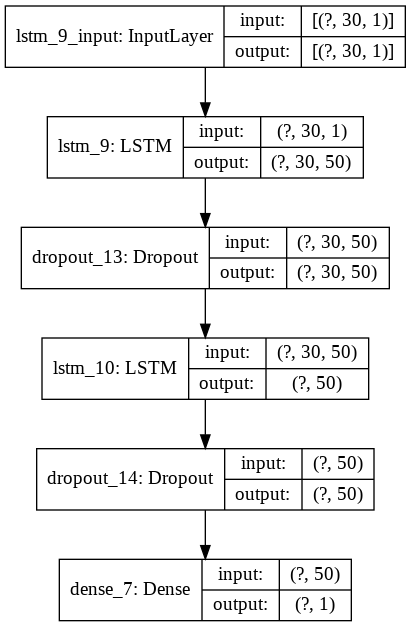

In [0]:
# Stacked LSTM layers con dropouts
model = keras.Sequential()

# return_sequences = True va usato quando l'output della LSTM serve come input 
# ad un'altra LSTM
model.add(layers.LSTM(50, return_sequences = True, input_shape=(X_train.shape[1], 1))) #50 imposta la dimensione dello spazio latente
model.add(layers.Dropout(0.2))

# nell'ultimo modulo LSTM non serve return_sequences = True
model.add(layers.LSTM(50))
model.add(layers.Dropout(0.2))

model.add(layers.Dense(1))

model.summary()
keras.utils.plot_model(model, show_shapes=True)

In [0]:
model.compile(optimizer='adam', loss='mean_squared_error')

history = model.fit(X_train, y_train,
                    epochs=100,
                    batch_size=32,
                    callbacks=[keras.callbacks.EarlyStopping(monitor='loss', patience=5)])

Epoch 1/100
63/63 [==============================] - 0s 6ms/step - loss: 0.0123
Epoch 2/100
63/63 [==============================] - 0s 6ms/step - loss: 0.0025
Epoch 3/100
63/63 [==============================] - 0s 6ms/step - loss: 0.0022
Epoch 4/100
63/63 [==============================] - 0s 6ms/step - loss: 0.0021
Epoch 5/100
63/63 [==============================] - 0s 6ms/step - loss: 0.0016
Epoch 6/100
63/63 [==============================] - 0s 6ms/step - loss: 0.0019
Epoch 7/100
63/63 [==============================] - 0s 6ms/step - loss: 0.0017
Epoch 8/100
63/63 [==============================] - 0s 6ms/step - loss: 0.0016
Epoch 9/100
63/63 [==============================] - 0s 6ms/step - loss: 0.0016
Epoch 10/100
63/63 [==============================] - 0s 6ms/step - loss: 0.0018


In [0]:
# Calcoliamo la predizione del modello su i dati del test set (set degli stessi dati nel periodo subito 
# successivo)

test_set = df_test.iloc[:, 1:2].values

#concateniamo il dataset di training (che contiene le sequenze precedenti a quelle 
#del test set) con il test set
df_total = pd.concat((df['Open'], df_test['Open']), axis = 0)
inputs = df_total[(len(df_total) - len(df_test) - timesteps - delay):].values
inputs = inputs.reshape(-1,1) #nota -1 significa che numpy ricava la dimensione dalla lunghezza dell'array
inputs = scaler.transform(inputs) #normalizzazione

X_test = []
for i in range(timesteps+delay, timesteps+delay+test_set.shape[0]):
    start = i-(timesteps+delay)
    end = i-delay
    X_test.append(inputs[start:end, 0])

X_test = np.array(X_test)
X_test = np.reshape(X_test, (X_test.shape[0], X_test.shape[1], 1))

# predizione sul test set
predicted_values = model.predict(X_test)

# riconvertiamo indietro da [0,1] ai valori originali dell'prezzo di borsa
predicted_values = scaler.inverse_transform(predicted_values)

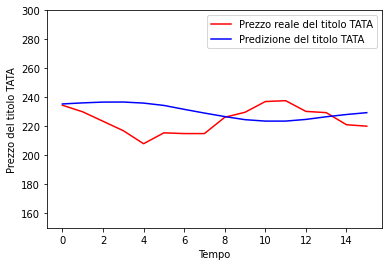

In [0]:
# Grafichiamo il risultato: predizione VS valore vero

plt.plot(test_set, color = 'red', label = 'Prezzo reale del titolo TATA')
plt.plot(predicted_values, color = 'blue', label = 'Predizione del titolo TATA')
plt.ylim(150, 300)
plt.xlabel('Tempo')
plt.ylabel('Prezzo del titolo TATA')
plt.legend()
plt.show()

Come prima cosa, notiamo che il processo di apprendimento dell'algoritmo si interrompe abbastanza presto, peraltro con valori della loss function ancora elevati. Come risultato, si ottiene una previsione completamente incompatibile con l'andamento reale.